<a href="https://colab.research.google.com/github/AndreaMarini01/NLP_tasks/blob/main/NLPsmote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kagglehub
%pip install tensorflow==2.12.0 scikit-learn==1.2.2

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  At

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Distribuzione finale delle classi (bilanciato): Counter({0: 3000, 1: 3000, 2: 3000})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 50)            500000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                          

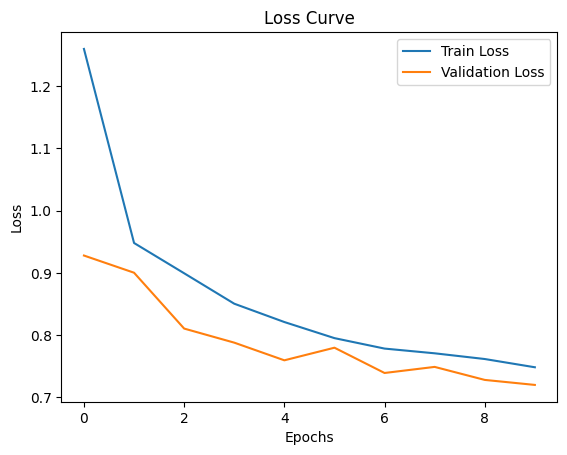

In [1]:
# Import librerie principali
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from collections import Counter

# Caricamento del dataset
path = kagglehub.dataset_download("thedevastator/hate-speech-and-offensive-language-detection")
file_path = os.path.join(path, "train.csv")
df = pd.read_csv(file_path)

# Pulizia del testo
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stopword_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(x):
    pattern = r'@\w*\b'
    no_pattern = r'&#\w*\b'
    x = re.sub(no_pattern, '', x)
    x = re.sub(pattern, '', x)
    x = x.replace('RT ', '')
    x = re.sub(r'[|!|:|"|;|\\\'|\\.]', '', x)
    tokens = word_tokenize(x)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.lower() not in stopword_set]
    return ' '.join(tokens)

df['tweet'] = df['tweet'].apply(clean_tweet)
df = df[df['tweet'] != '']  # Rimuove righe vuote

# Separazione delle feature e delle etichette
X = df['tweet']
y = df['class']

# Creazione e adattamento del livello TextVectorization
max_len = max(df['tweet'].apply(lambda x: len(x.split())))
text_vector = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=max_len)
text_vector.adapt(df['tweet'])

# Sbilanciamento: applicazione di RandomUnderSampler e SMOTE
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = {1: 3000, 2: 3000}  # Bilanciamento strategico
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_under, y_under = undersampler.fit_resample(pd.DataFrame(X), y)

# Vettorizzazione con TextVectorization
X_under_vectorized = text_vector(X_under.squeeze()).numpy()

# SMOTE per aumentare le classi minoritarie
oversampler = SMOTE(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X_under_vectorized, y_under)

# Distribuzione finale delle classi prima dello split
print("Distribuzione finale delle classi (bilanciato):", Counter(y_balanced))

# Split dei dati
x_train, x_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Creazione della matrice di embedding con GloVe
glove = api.load("glove-wiki-gigaword-50")
embedding_dim = 50
embedding_matrix = np.zeros((10000, embedding_dim))
vocabulary = text_vector.get_vocabulary()  # Ottieni la lista delle parole
word_index = {word: idx for idx, word in enumerate(vocabulary)}

for word, idx in word_index.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]

# Modello
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=False)(input_layer)
x = LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(embedding_layer)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Padding delle sequenze
X_balanced_padded = tf.keras.preprocessing.sequence.pad_sequences(X_balanced, maxlen=max_len)
x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

# Addestramento del modello
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_balanced_padded, y_balanced,
    validation_data=(x_test_padded, y_test),
    epochs=10, batch_size=32, callbacks=[early_stopping]
)

# Valutazione del modello
y_pred = np.argmax(model.predict(x_test_padded), axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred))
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

# Plot delle perdite
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()
